In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('oceanographic and meteorological dataset.csv')


Remover vento e correntes

In [3]:
colunas_para_remover = [
    'uo_cop', 'vo_cop', 'swh_cop', 'mwd_cop', 
    'mwp_cop', 'peak_period_cop', 'time','u10_era5','v10_era5'

]

df = df.drop(columns=colunas_para_remover, errors='ignore')
df.describe()

,mwd_era5,mwp_era5,swh_era5,pp1d_era5
count,7993.000000,7993.000000,7993.000000,7993.000000
mean,254.533087,8.491293,2.289455,10.429202
std,101.285307,1.508553,1.293055,2.219554
min,0.005922,5.044391,0.706308,4.360695
25%,247.110920,7.368544,1.306941,8.810890
50%,291.861820,8.303400,1.870715,10.276711
75%,320.586180,9.305229,2.910931,11.903175
max,359.915250,14.556703,8.823090,19.234710


Aterar variaveis mwd para sin e cos

In [4]:
def add_direction_features(df, col):
    df[f'{col}_sin'] = np.sin(np.deg2rad(df[col]))
    df[f'{col}_cos'] = np.cos(np.deg2rad(df[col]))
    return df
df = add_direction_features(df, 'mwd_era5')
df.describe()

,mwd_era5,mwp_era5,swh_era5,pp1d_era5,mwd_era5_sin,mwd_era5_cos
count,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000
mean,254.533087,8.491293,2.289455,10.429202,-0.482059,0.436709
std,101.285307,1.508553,1.293055,2.219554,0.585773,0.483577
min,0.005922,5.044391,0.706308,4.360695,-1.000000,-0.999988
25%,247.110920,7.368544,1.306941,8.810890,-0.926656,0.149474
50%,291.861820,8.303400,1.870715,10.276711,-0.712566,0.533409
75%,320.586180,9.305229,2.910931,11.903175,-0.268729,0.849137
max,359.915250,14.556703,8.823090,19.234710,1.000000,1.000000


Criar modelo para ver infuencia sem o vento

In [5]:
def create_supervised_dataset(df, features, target, lookback, horizon):
    X, y = [], []

    data = df[features + [target]].values

    for i in range(lookback, len(df) - horizon):
        X.append(data[i - lookback:i, :-1])
        y.append(data[i + horizon, -1])

    return np.array(X), np.array(y)

In [6]:
def temporal_train_val_test_split(X, y, train=0.7, val=0.1):
    n = len(X)
    n_train = int(n * train)
    n_val = int(n * (train + val))

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_val = X[n_train:n_val]
    y_val = y[n_train:n_val]

    X_test = X[n_val:]
    y_test = y[n_val:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def scale_data(X_train, X_test):
    n_samples, timesteps, n_features = X_train.shape

    scaler = StandardScaler()
    X_train_2d = X_train.reshape(-1, n_features)
    X_test_2d  = X_test.reshape(-1, n_features)

    X_train_scaled = scaler.fit_transform(X_train_2d)
    X_test_scaled  = scaler.transform(X_test_2d)

    X_train_scaled = X_train_scaled.reshape(n_samples, timesteps, n_features)
    X_test_scaled  = X_test_scaled.reshape(X_test.shape[0], timesteps, n_features)

    return X_train_scaled, X_test_scaled, scaler

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

def build_cnn_model(input_shape):
    model = Sequential([
        # Forma moderna de definir a entrada
        Input(shape=input_shape), 
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [9]:
HORIZONS = [1, 3, 6, 12, 24]
LOOKBACK = 24

TARGETS = ['swh_era5', 'mwp_era5', 'pp1d_era5']
FEATURES = [
    'swh_era5',
    'mwd_era5_sin',
    'mwd_era5_cos',
    'mwp_era5',
    'pp1d_era5'
]

  
results = []

for target in TARGETS:
    for h in HORIZONS:

        print(f'\nTreinar target={target} | horizonte={h}h')

        # criar dataset
        X, y = create_supervised_dataset(
            df,
            FEATURES,
            target,
            LOOKBACK,
            h
        )

        X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X, y)

        X_train, X_test, scaler = scale_data(X_train, X_test)

        model = build_cnn_model(X_train.shape[1:])

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val,y_val),
            epochs=20,
            batch_size=32,
            verbose=2
        )

        y_pred = model.predict(X_test).ravel()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        print(f'RMSE = {rmse:.3f} | MAE = {mae:.3f} | R2 = {r2:.3f}')

        results.append({
            'target': target,
            'horizon': h,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })


Treinar target=swh_era5 | horizonte=1h
Epoch 1/20
175/175 - 2s - 14ms/step - loss: 0.8759 - mae: 0.6131 - val_loss: 64.9012 - val_mae: 7.9337
Epoch 2/20
175/175 - 1s - 3ms/step - loss: 0.2413 - mae: 0.3350 - val_loss: 60.0022 - val_mae: 7.6375
Epoch 3/20
175/175 - 1s - 5ms/step - loss: 0.1865 - mae: 0.2997 - val_loss: 65.5186 - val_mae: 7.9843
Epoch 4/20
175/175 - 1s - 4ms/step - loss: 0.1465 - mae: 0.2598 - val_loss: 38.1464 - val_mae: 6.0930
Epoch 5/20
175/175 - 1s - 4ms/step - loss: 0.1427 - mae: 0.2550 - val_loss: 49.5058 - val_mae: 6.9420
Epoch 6/20
175/175 - 1s - 5ms/step - loss: 0.1366 - mae: 0.2487 - val_loss: 43.9449 - val_mae: 6.5434
Epoch 7/20
175/175 - 1s - 4ms/step - loss: 0.1241 - mae: 0.2406 - val_loss: 27.9402 - val_mae: 5.2224
Epoch 8/20
175/175 - 1s - 4ms/step - loss: 0.1216 - mae: 0.2351 - val_loss: 35.1698 - val_mae: 5.8541
Epoch 9/20
175/175 - 1s - 5ms/step - loss: 0.1136 - mae: 0.2309 - val_loss: 23.4504 - val_mae: 4.7886
Epoch 10/20
175/175 - 1s - 6ms/step - los

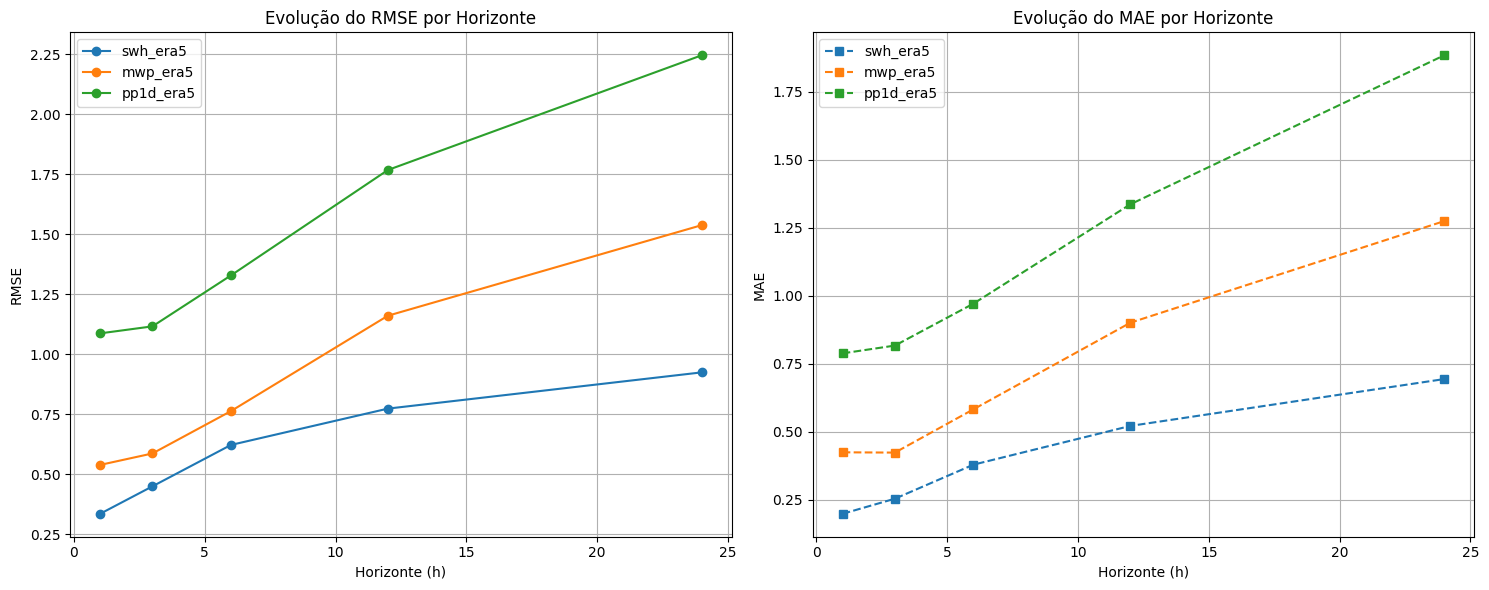

In [10]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(results)
# Criar uma figura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for target in TARGETS:
    subset = results_df[results_df['target'] == target]
    
    # Gráfico 1: RMSE
    ax1.plot(subset['horizon'], subset['rmse'], marker='o', label=target)
    
    # Gráfico 2: MAE
    ax2.plot(subset['horizon'], subset['mae'], marker='s', linestyle='--', label=target)

# Ajustes do gráfico de RMSE
ax1.set_title('Evolução do RMSE por Horizonte')
ax1.set_xlabel('Horizonte (h)')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(True)

# Ajustes do gráfico de MAE
ax2.set_title('Evolução do MAE por Horizonte')
ax2.set_xlabel('Horizonte (h)')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()


In [11]:
print("\n--- RESUMO DOS RESULTADOS (RMSE) ---")
pivot_rmse = results_df.pivot(index='horizon', columns='target', values='rmse')
display(pivot_rmse.round(4))

print("\n--- RESUMO DOS RESULTADOS (MAE) ---")
pivot_mae = results_df.pivot(index='horizon', columns='target', values='mae')
display(pivot_mae.round(4))



--- RESUMO DOS RESULTADOS (RMSE) ---


target,mwp_era5,pp1d_era5,swh_era5
horizon,,,
1,0.5395,1.0872,0.3359
3,0.5872,1.1164,0.4503
6,0.7635,1.3284,0.6226
12,1.1606,1.7674,0.7739
24,1.5379,2.2452,0.9248



--- RESUMO DOS RESULTADOS (MAE) ---


target,mwp_era5,pp1d_era5,swh_era5
horizon,,,
1,0.4249,0.7887,0.1990
3,0.4239,0.8173,0.2545
6,0.5830,0.9713,0.3795
12,0.9013,1.3365,0.5220
24,1.2748,1.8843,0.6942



===== Horizonte 1h =====

Epoch 1/20
140/140 - 3s - 19ms/step - loss: 0.0368 - val_loss: 0.0378
Epoch 2/20
140/140 - 1s - 4ms/step - loss: 0.0098 - val_loss: 0.0223
Epoch 3/20
140/140 - 1s - 5ms/step - loss: 0.0068 - val_loss: 0.0196
Epoch 4/20
140/140 - 1s - 4ms/step - loss: 0.0057 - val_loss: 0.0194
Epoch 5/20
140/140 - 1s - 4ms/step - loss: 0.0054 - val_loss: 0.0213
Epoch 6/20
140/140 - 1s - 4ms/step - loss: 0.0040 - val_loss: 0.0197
Epoch 7/20
140/140 - 1s - 4ms/step - loss: 0.0035 - val_loss: 0.0178
Epoch 8/20
140/140 - 1s - 5ms/step - loss: 0.0033 - val_loss: 0.0181
Epoch 9/20
140/140 - 1s - 4ms/step - loss: 0.0028 - val_loss: 0.0181
Epoch 10/20
140/140 - 1s - 7ms/step - loss: 0.0026 - val_loss: 0.0167
Epoch 11/20
140/140 - 1s - 5ms/step - loss: 0.0025 - val_loss: 0.0159
Epoch 12/20
140/140 - 1s - 5ms/step - loss: 0.0022 - val_loss: 0.0168
Epoch 13/20
140/140 - 1s - 5ms/step - loss: 0.0024 - val_loss: 0.0148
Epoch 14/20
140/140 - 1s - 5ms/step - loss: 0.0020 - val_loss: 0.0148
E

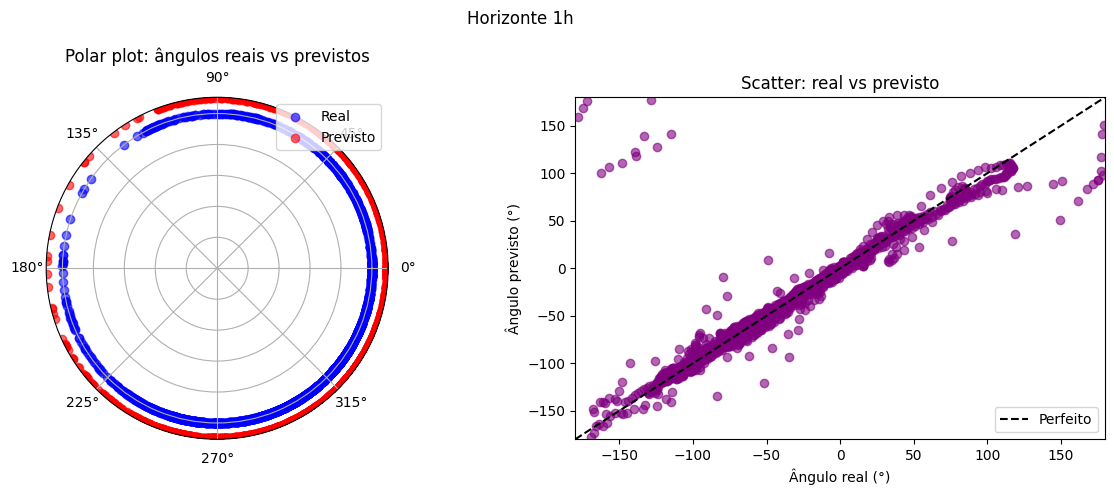


===== Horizonte 3h =====

Epoch 1/20
140/140 - 3s - 18ms/step - loss: 0.0574 - val_loss: 0.0504
Epoch 2/20
140/140 - 1s - 5ms/step - loss: 0.0207 - val_loss: 0.0488
Epoch 3/20
140/140 - 1s - 6ms/step - loss: 0.0138 - val_loss: 0.0403
Epoch 4/20
140/140 - 1s - 5ms/step - loss: 0.0109 - val_loss: 0.0459
Epoch 5/20
140/140 - 1s - 4ms/step - loss: 0.0096 - val_loss: 0.0436
Epoch 6/20
140/140 - 1s - 5ms/step - loss: 0.0088 - val_loss: 0.0419
Epoch 7/20
140/140 - 1s - 6ms/step - loss: 0.0085 - val_loss: 0.0376
Epoch 8/20
140/140 - 1s - 5ms/step - loss: 0.0073 - val_loss: 0.0393
Epoch 9/20
140/140 - 1s - 6ms/step - loss: 0.0067 - val_loss: 0.0378
Epoch 10/20
140/140 - 1s - 4ms/step - loss: 0.0062 - val_loss: 0.0328
Epoch 11/20
140/140 - 1s - 5ms/step - loss: 0.0059 - val_loss: 0.0363
Epoch 12/20
140/140 - 1s - 9ms/step - loss: 0.0057 - val_loss: 0.0324
Epoch 13/20
140/140 - 1s - 4ms/step - loss: 0.0048 - val_loss: 0.0325
Epoch 14/20
140/140 - 1s - 4ms/step - loss: 0.0050 - val_loss: 0.0337
E

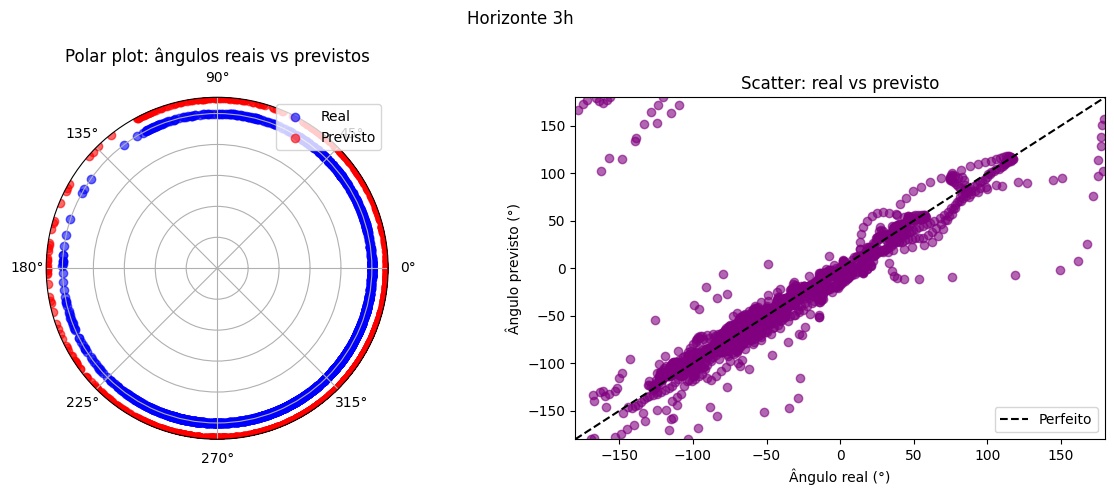


===== Horizonte 6h =====

Epoch 1/20
140/140 - 3s - 19ms/step - loss: 0.0744 - val_loss: 0.0760
Epoch 2/20
140/140 - 1s - 5ms/step - loss: 0.0277 - val_loss: 0.0700
Epoch 3/20
140/140 - 1s - 4ms/step - loss: 0.0216 - val_loss: 0.0637
Epoch 4/20
140/140 - 1s - 5ms/step - loss: 0.0196 - val_loss: 0.0623
Epoch 5/20
140/140 - 1s - 5ms/step - loss: 0.0166 - val_loss: 0.0679
Epoch 6/20
140/140 - 1s - 5ms/step - loss: 0.0144 - val_loss: 0.0675
Epoch 7/20
140/140 - 1s - 5ms/step - loss: 0.0134 - val_loss: 0.0615
Epoch 8/20
140/140 - 1s - 4ms/step - loss: 0.0125 - val_loss: 0.0665
Epoch 9/20
140/140 - 1s - 4ms/step - loss: 0.0118 - val_loss: 0.0598
Epoch 10/20
140/140 - 1s - 5ms/step - loss: 0.0107 - val_loss: 0.0593
Epoch 11/20
140/140 - 1s - 6ms/step - loss: 0.0102 - val_loss: 0.0645
Epoch 12/20
140/140 - 1s - 5ms/step - loss: 0.0100 - val_loss: 0.0641
Epoch 13/20
140/140 - 1s - 5ms/step - loss: 0.0100 - val_loss: 0.0605
Epoch 14/20
140/140 - 1s - 5ms/step - loss: 0.0083 - val_loss: 0.0622
E

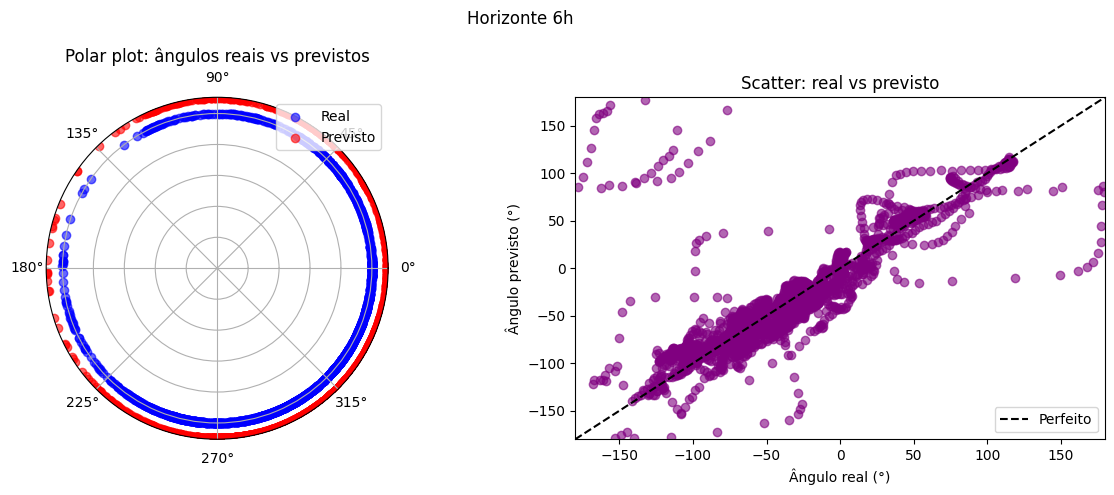


===== Horizonte 12h =====

Epoch 1/20
140/140 - 3s - 19ms/step - loss: 0.1010 - val_loss: 0.1271
Epoch 2/20
140/140 - 1s - 4ms/step - loss: 0.0530 - val_loss: 0.1132
Epoch 3/20
140/140 - 1s - 4ms/step - loss: 0.0429 - val_loss: 0.1133
Epoch 4/20
140/140 - 1s - 5ms/step - loss: 0.0367 - val_loss: 0.1159
Epoch 5/20
140/140 - 1s - 4ms/step - loss: 0.0332 - val_loss: 0.1308
Epoch 6/20
140/140 - 1s - 4ms/step - loss: 0.0281 - val_loss: 0.1311
Epoch 7/20
140/140 - 1s - 4ms/step - loss: 0.0264 - val_loss: 0.1408
Epoch 8/20
140/140 - 1s - 5ms/step - loss: 0.0227 - val_loss: 0.1359
Epoch 9/20
140/140 - 1s - 4ms/step - loss: 0.0217 - val_loss: 0.1389
Epoch 10/20
140/140 - 1s - 4ms/step - loss: 0.0183 - val_loss: 0.1307
Epoch 11/20
140/140 - 1s - 4ms/step - loss: 0.0171 - val_loss: 0.1575
Epoch 12/20
140/140 - 1s - 5ms/step - loss: 0.0162 - val_loss: 0.1465
Epoch 13/20
140/140 - 1s - 5ms/step - loss: 0.0163 - val_loss: 0.1476
Epoch 14/20
140/140 - 1s - 4ms/step - loss: 0.0142 - val_loss: 0.1381


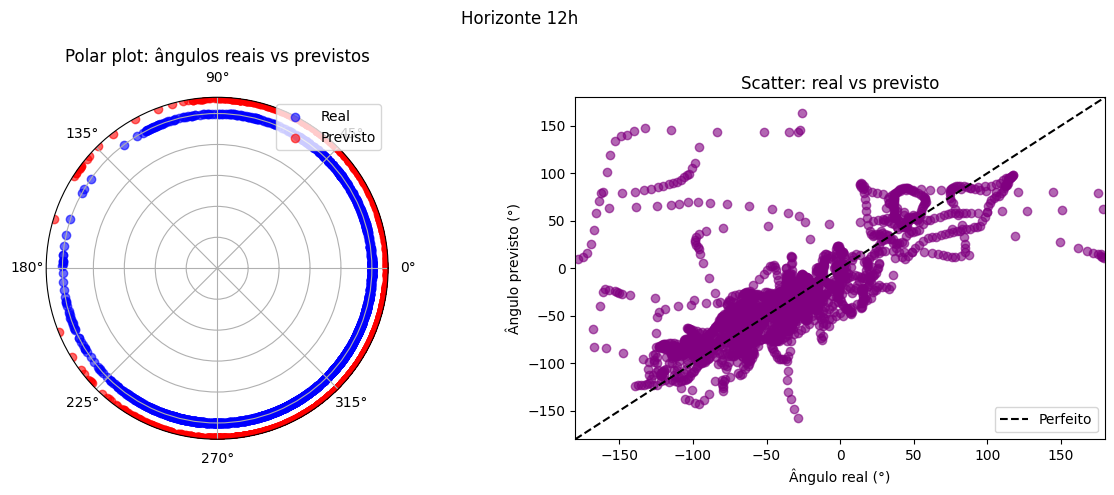


===== Horizonte 24h =====

Epoch 1/20
139/139 - 2s - 17ms/step - loss: 0.1298 - val_loss: 0.2514
Epoch 2/20
139/139 - 1s - 8ms/step - loss: 0.0802 - val_loss: 0.2324
Epoch 3/20
139/139 - 1s - 4ms/step - loss: 0.0636 - val_loss: 0.2610
Epoch 4/20
139/139 - 1s - 4ms/step - loss: 0.0531 - val_loss: 0.2808
Epoch 5/20
139/139 - 1s - 4ms/step - loss: 0.0474 - val_loss: 0.2818
Epoch 6/20
139/139 - 1s - 4ms/step - loss: 0.0406 - val_loss: 0.2714
Epoch 7/20
139/139 - 1s - 4ms/step - loss: 0.0338 - val_loss: 0.2880
Epoch 8/20
139/139 - 1s - 5ms/step - loss: 0.0303 - val_loss: 0.3053
Epoch 9/20
139/139 - 1s - 5ms/step - loss: 0.0243 - val_loss: 0.2845
Epoch 10/20
139/139 - 1s - 5ms/step - loss: 0.0215 - val_loss: 0.2811
Epoch 11/20
139/139 - 1s - 4ms/step - loss: 0.0192 - val_loss: 0.2690
Epoch 12/20
139/139 - 1s - 4ms/step - loss: 0.0183 - val_loss: 0.2841
Epoch 13/20
139/139 - 1s - 5ms/step - loss: 0.0166 - val_loss: 0.2860
Epoch 14/20
139/139 - 1s - 4ms/step - loss: 0.0147 - val_loss: 0.2974


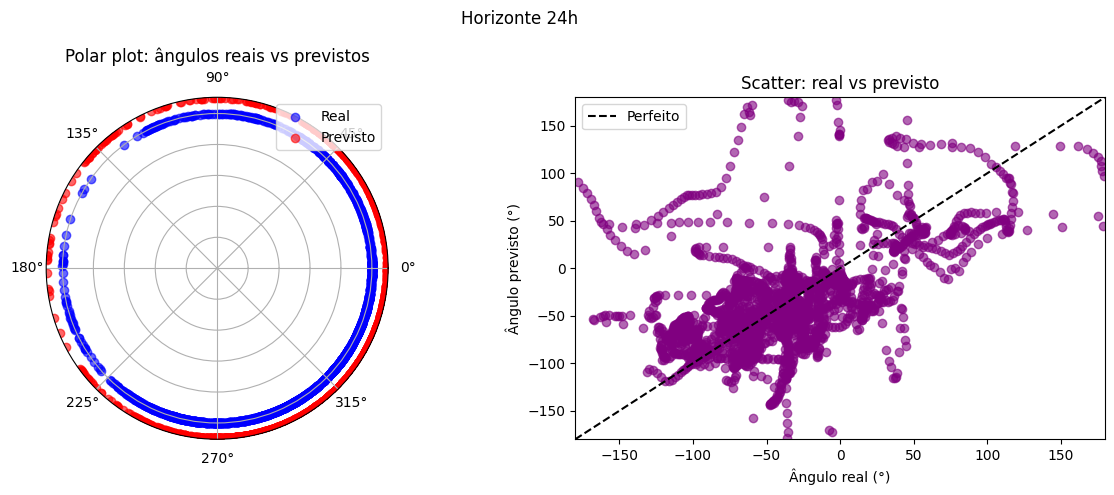

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

HORIZONS = [1, 3, 6, 12, 24]
LOOKBACK = 24

TARGETS = ['mwd_era5_sin','mwd_era5_cos']  # prever ambos juntos
FEATURES_ERA5 = [
    'swh_era5',
    'mwd_era5_sin',
    'mwd_era5_cos',
    'mwp_era5',
    'pp1d_era5'
]

results = []

def angular_error_deg(true, pred):
    """Diferença angular mínima em graus"""
    delta = np.arctan2(np.sin(np.deg2rad(pred - true)),
                       np.cos(np.deg2rad(pred - true)))
    return np.rad2deg(delta)

def plot_angle_predictions(y_true_angle, y_pred_angle, title="Predição de ângulos"):
    """Polar plot e scatter plot de ângulos"""
    fig = plt.figure(figsize=(12,5))

    # Polar plot
    ax1 = fig.add_subplot(1,2,1, polar=True)
    ax1.scatter(np.deg2rad(y_true_angle), np.ones_like(y_true_angle),
                label="Real", alpha=0.6, color="blue")
    ax1.scatter(np.deg2rad(y_pred_angle), np.ones_like(y_pred_angle)*1.1,
                label="Previsto", alpha=0.6, color="red")
    ax1.set_yticklabels([])
    ax1.set_title("Polar plot: ângulos reais vs previstos")
    ax1.legend(loc='upper right')

    # Scatter real vs previsto
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(y_true_angle, y_pred_angle, alpha=0.6, color="purple")
    ax2.plot([-180,180], [-180,180], 'k--', label="Perfeito")
    ax2.set_xlim(-180,180)
    ax2.set_ylim(-180,180)
    ax2.set_xlabel("Ângulo real (°)")
    ax2.set_ylabel("Ângulo previsto (°)")
    ax2.set_title("Scatter: real vs previsto")
    ax2.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
def temporal_train_test_split(X, y, train_ratio=0.7):
    n_train = int(len(X) * train_ratio)
    return X[:n_train], X[n_train:], y[:n_train], y[n_train:]
def create_supervised_dataset(df, features, target, lookback, horizon):
    X, y = [], []
    
    data = df[features + target].values  # target já pode ser lista
    n_features = len(features)
    n_targets = len(target)

    for i in range(lookback, len(df) - horizon):
        # X = todos os features nos últimos 'lookback' timesteps
        X.append(data[i - lookback:i, :n_features])
        # y = todos os targets no passo 'horizon' à frente
        y.append(data[i + horizon, n_features:n_features + n_targets])

    X = np.array(X)
    y = np.array(y)
    
    return X, y



def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='linear'))  # sin e cos
    model.compile(optimizer='adam', loss='mse')
    return model

# ===== Loop de treino =====
for h in HORIZONS:

    print(f'\n===== Horizonte {h}h =====\n')

    # criar dataset com os dois targets
    X, y = create_supervised_dataset(
        df,
        FEATURES_ERA5,
        target=TARGETS,  # sin e cos juntos
        lookback=LOOKBACK,
        horizon=h
    )

    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)
    X_train, X_test, scaler = scale_data(X_train, X_test)

    model = build_cnn_model(X_train.shape[1:])
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        verbose=2
    )

    # Previsões
    y_pred = model.predict(X_test)

    # Reconstruir ângulo
    y_test_angle = np.rad2deg(np.arctan2(y_test[:,0], y_test[:,1]))
    y_pred_angle = np.rad2deg(np.arctan2(y_pred[:,0], y_pred[:,1]))

    # Erro angular mínimo
    angle_error = angular_error_deg(y_test_angle, y_pred_angle)

    # Métricas
    rmse_sin_cos = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_sin_cos  = mean_absolute_error(y_test, y_pred)
    r2_sin_cos   = r2_score(y_test, y_pred)

    mae_angle = np.mean(np.abs(angle_error))
    rmse_angle = np.sqrt(np.mean(angle_error**2))

    print(f'MSE/MAE/R2 (sin+cos): RMSE={rmse_sin_cos:.3f}, MAE={mae_sin_cos:.3f}, R2={r2_sin_cos:.3f}')
    print(f'Erro angular: MAE={mae_angle:.2f}°, RMSE={rmse_angle:.2f}°')

    # Guardar resultados
    results.append({
        "horizon": h,
        "rmse_sin_cos": rmse_sin_cos,
        "mae_sin_cos": mae_sin_cos,
        "r2_sin_cos": r2_sin_cos,
        "mae_angle": mae_angle,
        "rmse_angle": rmse_angle,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_test_angle": y_test_angle,
        "y_pred_angle": y_pred_angle
    })

    # Plot polar + scatter
    plot_angle_predictions(y_test_angle, y_pred_angle, title=f'Horizonte {h}h')



In [14]:
import pandas as pd

# Extrair apenas os valores importantes para a tabela
df_results = pd.DataFrame([
    {
        'Horizon (h)': r['horizon'],
      
        'RMSE (°)': r['rmse_angle'],
        'MAE (°)': r['mae_angle']
    }
    for r in results
])

print(df_results)

   Horizon (h)   RMSE (°)    MAE (°)
0            1  10.625170   4.859369
1            3  14.652680   7.904689
2            6  24.387270  14.524358
3           12  34.978366  22.401403
4           24  48.976568  36.060782
